#### Data Handling (example 02)
MemoCell has an own data object that can be loaded with cell count data or summary statistics (mean, variance, covariance). A data object, together with a set of networks (see example 01), can then be used for MemoCell inferences (see example 03).

In [1]:
import memocell as me
import numpy as np
import matplotlib.pyplot as plt
import pickle

/Users/mlanghinrichs/Documents/Studium/PhD/01_projects/memo_cell/memocell/memocell/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


##### create data object from cell counts

In [2]:
# below we create a small data object of a cell division process X_t; the cell 
# numbers of 20 dividing clones, each starting from a single cell, were 
# observed at t=10; this data set is also used for inferences in example 03

# the raw cell counts (some made up numbers, coming from a true model, see at the end)
count_data = np.array([[[4]], [[4]], [[2]], [[4]], [[4]], [[5]], [[6]], [[6]], [[4]], [[5]], 
                       [[4]], [[3]], [[4]], [[4]], [[7]], [[5]], [[4]], [[4]], [[5]], [[6]]])

# NOTE: memocell requires the shape (#repeats, #cell types, #time points) for numpy array count_data
# print(count_data.shape) -> (20, 1, 1)

# NOTE: count data in memocell can be a time-series; such data can originate 
# from live-time monitoring (observing the same realisation over time) 
# OR from an ensemble of repeated snapshot/single-time-point measurements 
# at different time points

In [3]:
# memocell data objects can be constructed as follows;
# summary statistics with associated standard errors are
# automatically obtained by non-parametric bootstrapping
time_values = np.array([10.0])

data_10 = me.Data('data_cell_div_t10')
data_10.load(['X_t',], time_values, count_data)

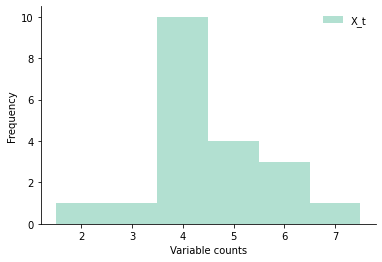

In [4]:
# plot the histogram of cell counts at a given time point
# (by index, 0 = first and only time point here)
me.plots.data_hist_variables_plot(data_10, 0);

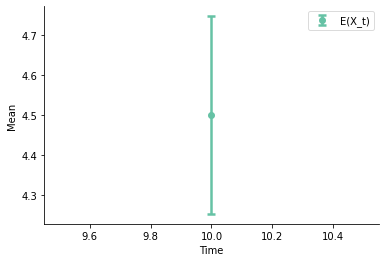

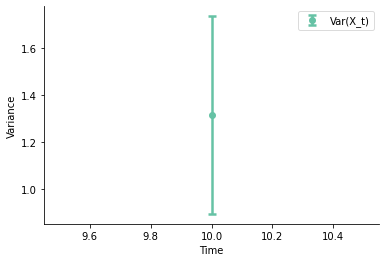

In [5]:
# plot the summary statistics obtained by memocell
# (mean and variance with bootstrapped standard errors; 
# covariance is empty as we only have one cell type here)
me.plots.data_mean_plot(data_10)
me.plots.data_variance_plot(data_10);

In [6]:
# NOTE: the code snippets below can be used to save and 
# then subsequently load the memocell data object for all 
# future inferences

### save
# with open('data_cell_div_t10.pickle', 'wb') as file_:
#     pickle.dump(data_10, file_)

### load
# data_10 = pickle.load(open('data_cell_div_t10.pickle', 'rb'))

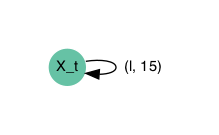

In [7]:
### ground truth model (just as background info)
# the above data was sampled from stochastic simulations of 
# a cell division ground truth model; we used:

# pretty tight, 15-substep Erlang division times
# in a self-renewing division model for X_t
topology = [{'start': 'X_t', 'end': 'X_t',
             'rate_symbol': 'l',
             'type': 'S -> S + S', 'reaction_steps': 15}]

net = me.Network('net_div_erl15')
net.structure(topology)

me.plots.net_main_plot(net);

# and simulated by
num_iter = 20
initial_values_type = 'synchronous'
initial_values = {'X_t': 1}
theta_values = {'l': 0.255}
time_values = np.array([0.0, 10.0])
variables = {'X_t': ('X_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, theta_values, time_values,
                                        initial_values_type, initial_gillespie=initial_values)[1])

# sim_res can be used as count_data (where we used t=10 only)
sim_res = np.array(res_list)

# see also example 01 and "create *in silico* data 
# from a ground truth model" in this example
###

##### create data object from summary statistics

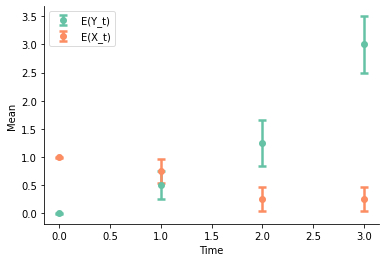

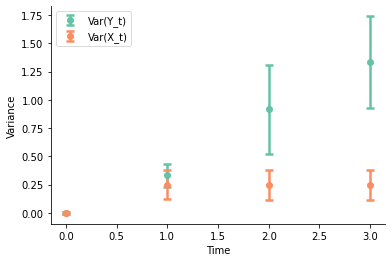

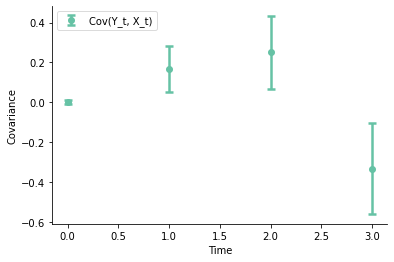

In [8]:
# memocell can also be used to load summary statistics (mean, 
# variance, covariance) directly, instead of providing count data

# NOTE: this might be useful for two reasons:
# 1) you don't have count data; you may have population-level
#    mean data, which you can then directly load (leaving 
#    variance and covariance also empty)
# 2) you have count data, but in a different format as currently 
#    supported by memocell; for example, you have a different number 
#    of experimental repeats for different time points; you can 
#    bootstrap your data yourself and load it as summary statistics

# we load some made up summary statistics for a two cell type process
variables = ['Y_t', 'X_t']
time_values = np.linspace(0.0, 3.0, num=4)

# summary statistics have to be provided as numpy arrays
# ss[0, :, :] contain the statistics and ss[1, :, :] the standard errors
ss_mean = np.array([[[0.,         0.5,        1.25,       3.          ],
                     [1.,         0.75,       0.25,       0.25        ]],
                    [[0.01,         0.25096378, 0.41313568, 0.50182694],
                     [0.01,         0.21847682, 0.21654396, 0.21624184]]])

ss_var = np.array([[[0.,         0.33333333, 0.91666667, 1.33333333  ],
                    [0.,         0.25,       0.25,       0.25        ]],
                   [[0.01,         0.10247419, 0.39239737, 0.406103  ],
                    [0.01,         0.13197367, 0.13279328, 0.13272021]]])

ss_cov = np.array([[[ 0.,          0.16666667,  0.25,       -0.33333333  ]],
                   [[ 0.01,          0.11379549,  0.18195518,  0.22722941]]])

# all summary stats require shape (2, #mean/var/cov statistics, #time values)
# print(ss_mean.shape) -> (2, 2, 4)

# to load summary stats to a memocell data object set 
# count_data=None and use data_type='summary' and the 
# optional arguments as below
data_ss = me.Data('data_summary_stats')
data_ss.load(variables, time_values, None, data_type='summary',
            mean_data=ss_mean, var_data=ss_var, cov_data=ss_cov)

# the loaded data can be plotted
me.plots.data_mean_plot(data_ss)
me.plots.data_variance_plot(data_ss)
me.plots.data_covariance_plot(data_ss);

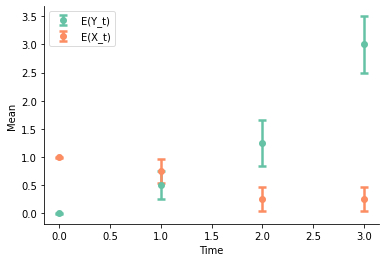

In [9]:
# to load mean-only data, just leave out the variance 
# and covariance optional arguments
ss_mean = np.array([[[0.,         0.5,        1.25,       3.],
                      [1.,         0.75,       0.25,       0.25]],
                     [[0.01,         0.25096378, 0.41313568, 0.50182694],
                      [0.01,         0.21847682, 0.21654396, 0.21624184]]])

data_ss_mean = me.Data('data_summary_stats_mean_only')
data_ss_mean.load(variables, time_values, None, data_type='summary',
                mean_data=ss_mean)

me.plots.data_mean_plot(data_ss_mean);

##### create *in silico* data from a ground truth model

MemoCell data objects can be created based on a set of stochastic simulations from a known model. Such *in silico* data can be very helpful to find out what information is contained *in principle* in the data to address the questions of interest (as one can work with a "perfect" data set with a high number of simulation repeats that are typically not feasible in real experiments). More data does not always mean that everything can be inferred; there may always be structurally unidentifiable features!

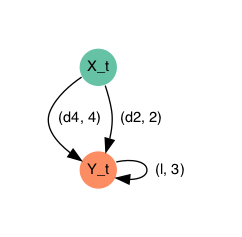

In [11]:
# cell activation division process
# (the same model as in example 01 for network definition 
# and simulations, see there for more details)
topology = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

net = me.Network('net_true')
net.structure(topology)

me.plots.net_main_plot(net);

In [12]:
# run many stochastic realisations of the ground truth model
# from which in silico data is obtained in the next step

# simulation repeats 
# (pretending a high number of experimental repeats)
num_iter = 100 # or 1000, 10000, ...

variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}
theta_values = {'l': 0.06, 'd4': 0.03, 'd2': 0.04}
time_values = np.linspace(0.0, 54.0, num=14)
initial_values_type = 'synchronous'
initial_values_gillespie = {'X_t': 1, 'Y_t': 0}

# append each stochastic simulation to a list
sim = me.Simulation(net)
res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, theta_values, time_values,
            initial_values_type, initial_gillespie=initial_values_gillespie)[1])

# convert to array and check the shape
# count data requires shape (#repeats, #variables, #time points)
sim_res = np.array(res_list)
print(sim_res.shape)

(100, 2, 14)


In [13]:
# load count data with memocell which is automatically 
# processed to summary statistics of mean, 
# variance and covariance with standard errors
data_in_sil = me.Data('data_in_silico')
data_in_sil.load(['X_t', 'Y_t'], time_values, sim_res, basic_sigma=1/num_iter)

# NOTE: basic_sigma is used to assign a minimal non-zero standard 
# error for the summary statistics at the first time point (deterministic 
# initial distribution); otherwise log-likelihood will encounter division 
# by zero; this choice may need careful considerations in some cases 
# (see API docs or methods in release paper)

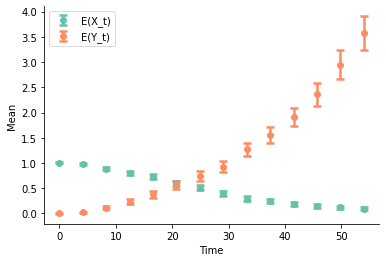

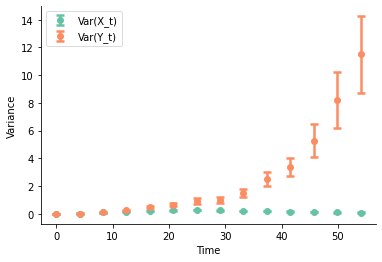

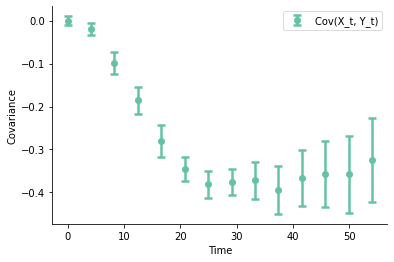

In [14]:
# plot the summary statistics
me.plots.data_mean_plot(data_in_sil)
me.plots.data_variance_plot(data_in_sil)
me.plots.data_covariance_plot(data_in_sil);

In [15]:
# NOTE: the code snippets below can be used to save and 
# then subsequently load the memocell data object for all 
# future inferences

### save
# with open('some_folder/my_in_silico_data.pickle', 'wb') as file_:
#     pickle.dump(data_in_sil, file_)

### load
# data_in_sil = pickle.load(open('some_folder/my_in_silico_data.pickle', 'rb'))